In [1]:
from datasets import load_dataset

from PIL import Image
import torch.nn.functional as F
import os
from tqdm import tqdm
import torch
import numpy as np
from utils import img_to_tensor, tensor_to_image, gather

/Users/matt/anaconda3/envs/guided_diffusion/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import constants
import numpy as np
from PIL import Image, ImageOps
import math


def render(map):
    graphics = {
        ".": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/empty.png").convert('RGBA'),
        "w": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/solid.png").convert('RGBA'),
        "A": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/player.png").convert('RGBA'),
        "+": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/key.png").convert('RGBA'),
        "g": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/door.png").convert('RGBA'),
        "2": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/spider.png").convert('RGBA'),
        "1": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/bat.png").convert('RGBA'),
        "3": Image.open("/Users/matt/guided-diffusion/gym_pcgrl/envs/probs/zelda/scorpion.png").convert('RGBA'),
    }
    tile_size = 16
    border_size = (1,1)
    tiles = [".", "w", "A", "+", "g", "1", "3", "2"]
    border_tile = tiles[1]

    full_width = len(map[0])+2*border_size[0]
    full_height = len(map)+2*border_size[1]
    lvl_image = Image.new("RGBA", (full_width*tile_size, full_height*tile_size), (0,0,0,255))
    for y in range(full_height):
        for x in range(border_size[0]):
            lvl_image.paste(graphics[border_tile], (x*tile_size, y*tile_size, (x+1)*tile_size, (y+1)*tile_size))
            lvl_image.paste(graphics[border_tile], ((full_width-x-1)*tile_size, y*tile_size, (full_width-x)*tile_size, (y+1)*tile_size))
    for x in range(full_width):
        for y in range(border_size[1]):
            lvl_image.paste(graphics[border_tile], (x*tile_size, y*tile_size, (x+1)*tile_size, (y+1)*tile_size))
            lvl_image.paste(graphics[border_tile], (x*tile_size, (full_height-y-1)*tile_size, (x+1)*tile_size, (full_height-y)*tile_size))
    for y in range(len(map)):
        for x in range(len(map[y])):
            lvl_image.paste(graphics[map[y][x]], ((x+border_size[0])*tile_size, (y+border_size[1])*tile_size, (x+border_size[0]+1)*tile_size, (y+border_size[1]+1)*tile_size))
    return lvl_image

# 
char_rgb_tuples = [
    ("g",[153, 76, 0]),
    ("+",[255, 255, 0]),
    ("A",[255, 229, 204]),
    ("1",[0, 0, 0]),
    ("2",[153, 51, 255]),
    ("3",[255, 0, 0]),
    ("w",[153, 0, 0]),
    (".",[192, 192, 192])
]


def pixel_map_to_image_map(map):
    arr = np.asarray(im)
    tiles = []
    for row in arr:
        new_row = []
        for rgb in row:
            r, g, b = rgb
            candidates = []
            for k, v in char_rgb_tuples:
                candidates.append(sum([math.sqrt((r-v[0])**2), math.sqrt((g-v[1])**2),math.sqrt((b-v[2])**2)]))
            new_row.append(char_rgb_tuples[np.argmin(candidates)][0])
        tiles.append(new_row)
    return render(tiles)
    


def to_2d_array_level(file_name):
    level = []

    with open(file_name, 'r') as f:
        rows = f.readlines()[1: len(f.readlines()) - 1]
        for row in rows:
            level.append(row[1: len(row) -1])
    
    pixel_level = []
    for row in level:
        new_row = []
        for char in row:
            if char != '\n':
                new_row.append(
                    constants.ZELDA_TILE_TO_RGB_VALUE_MAP[char]
                )
        pixel_level.append(new_row)
    
    pixel_level = np.array(pixel_level).reshape((32,32,3))
    return pixel_level


def gray_scale_np_arr_to_gray_scale_pil_img(gray_scale_np_arr):
    img = np.asarray(gray_scale_np_arr, dtype=np.uint8)
    return Image.fromarray(img)


goal_maps_path = "/Users/matt/guided-diffusion/zelda_playable_maps"
gray_scale_goal_maps_lst = []
for file in os.listdir(goal_maps_path):
    gray_scale_goal_map = to_2d_array_level(f"{goal_maps_path}/{file}")
    gray_scale_goal_maps_lst.append(gray_scale_np_arr_to_gray_scale_pil_img(gray_scale_goal_map))

## Add Noising to x_t given x_t-1

In [12]:
# add noise to x_t given x_t-1 --> q(x_t, x_t-1)
# def q_xt_xtminus1(xtm1, t, beta):
# #     print(f"shape of beta is {beta.shape}")
# #     print(f"beta is {beta}")
# #     print(f"beta is {beta}")
#     mean = gather(1. - beta, t) ** 0.5 * xtm1 # √(1−βt)*xtm1
# #     print(f"mean after gather is {mean.shape}")
#     var = gather(beta, t) # βt I - what is I?
#     eps = torch.randn_like(xtm1) # Noise shaped like xtm1
#     return mean + (var ** 0.5) * eps


# def add_noise_xt_from_xtminus1(n_steps, start_img, beta):
#     # Show im at different stages
#     ims = []
#     x = img_to_tensor(start_im).squeeze()
#     for t in range(n_steps):
#         # Store images every 20 steps to show progression
#         if t%20 == 0:
#             ims.append(tensor_to_image(x))

#          # Calculate Xt given Xt-1 (i.e. x from the previous iteration)
#         t = torch.tensor(t, dtype=torch.long) # t as a tensor
#         x = q_xt_xtminus1(x, t, beta) # Modify x using our function above

#     return ims
        

# # Refactor to load in local cifar data
# start_im = playable_maps[gray_scale_goal_maps_lst]
# n_steps = 100
# # Beta schedule --> i.e. how often to add noise
# beta = torch.linspace(0.0001, 0.04, n_steps)
# ims = add_noise_xt_from_xtminus1(n_steps, start_im, beta)

# # Display the images
# image = Image.new('RGB', size=(13, 9))
# for i, im in enumerate(ims):
#     image.paste(im, ((i%5)*13, 0))
# image.resize((13*4*5, 9*4), Image.NEAREST)

## Add Noising  to x_t given x_0

/Users/matt/anaconda3/envs/guided_diffusion/lib/python3.7/site-packages/ipykernel_launcher.py:43: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


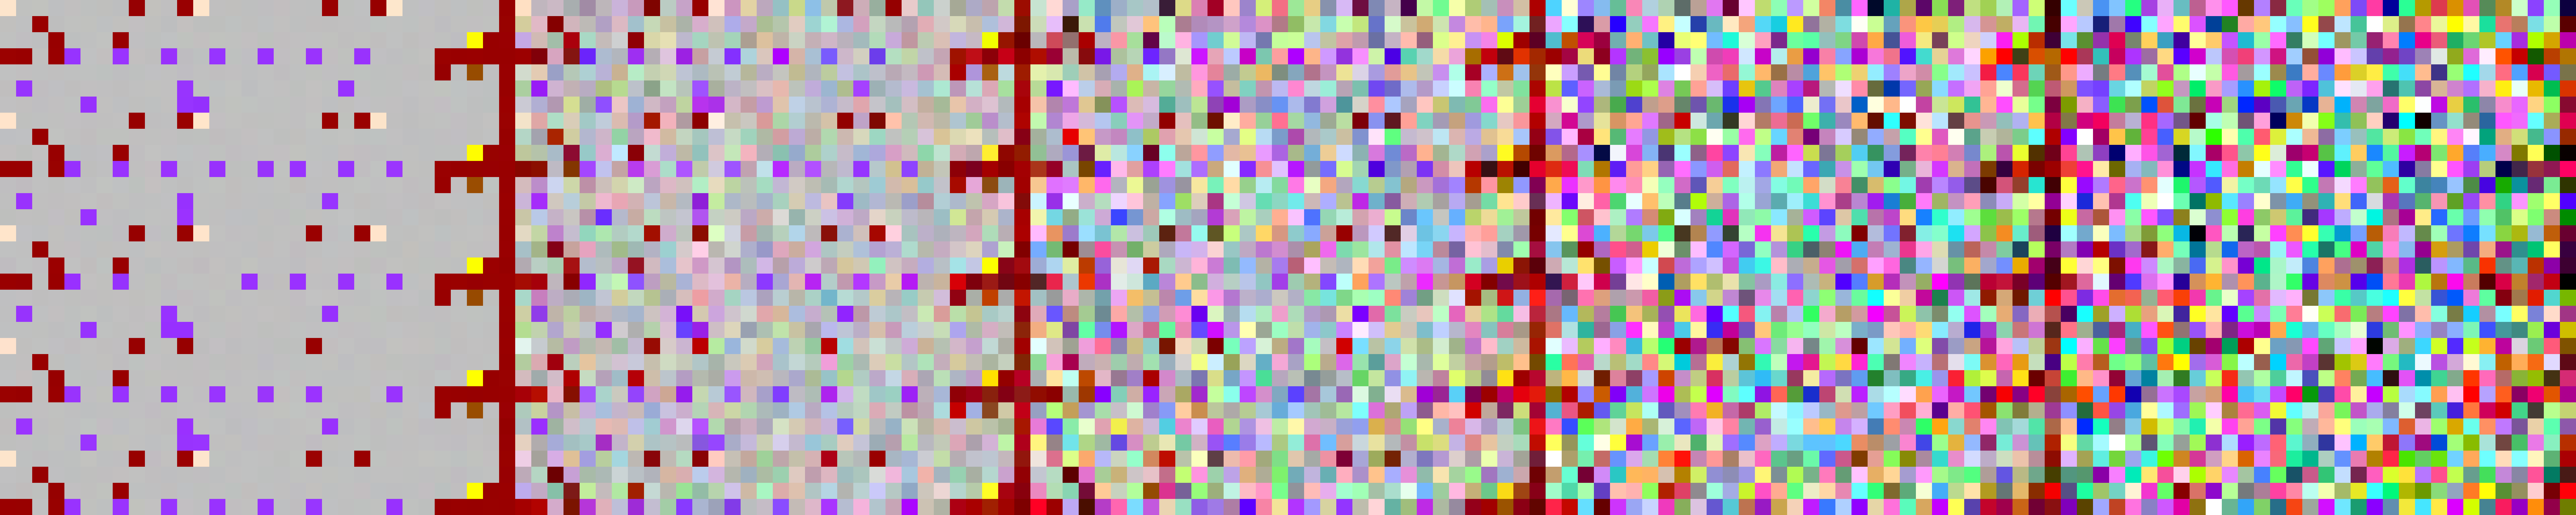

In [13]:
"""
From paper, they reparameterize 
"""

UPSCALE_FACTOR = 50
n_steps = 25
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

def q_xt_x0(x0, t):
    mean = gather(alpha_bar, t) ** 0.5 * x0 # now alpha_bar
    var = 1-gather(alpha_bar, t) # (1-alpha_bar)
    eps = torch.randn_like(x0)
    return mean + (var ** 0.5) * eps


def add_noise_xt_from_x0(start_img, t_list):
    # Show im at different stages
    ims = []
    x = img_to_tensor(start_im).squeeze()
    for t in t_list:
        # Calculate Xt given X0 (i.e. x from the previous iteration)
        t = torch.tensor(t, dtype=torch.long) # t as a tensor
        x = q_xt_x0(x, t) # Modify x using our function above
        ims.append(tensor_to_image(x))

    return ims

# Show im at different stages
ims = []
start_im = gray_scale_goal_maps_lst[0]
x0 = img_to_tensor(start_im)#.squeeze()
t_list = [0, 5, 10, 15, 20]
ims = add_noise_xt_from_x0(start_im, t_list)


image = Image.new('RGB', size=(32*5, 32))
start_image_maps = []
for i, im in enumerate(ims):
    image.paste(im, ((i%5)*32, 0))
    start_image_maps.append(pixel_map_to_image_map(im))
image.resize((32*5*UPSCALE_FACTOR, 32*UPSCALE_FACTOR), Image.NEAREST)

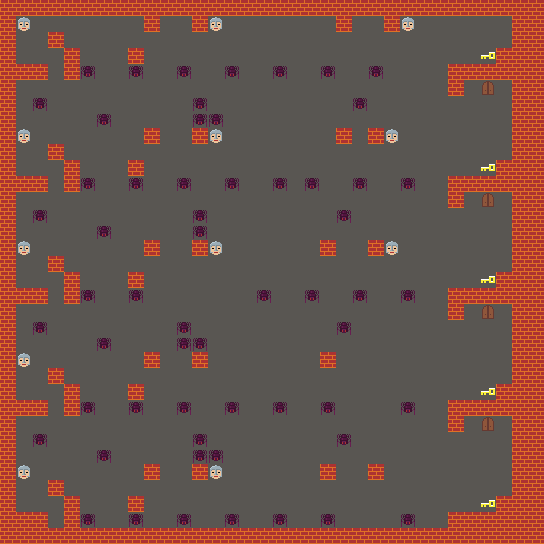

In [5]:
display(start_image_maps[0])

## Training

In [14]:
from unet import UNet
import pathlib

model_name =  'diffusion_model_latest.pt'

# Create the model
unet = UNet(n_channels=32)

# Set up some parameters
n_steps = 100
beta = torch.linspace(0.0001, 0.04, n_steps)
alpha = 1. - beta
alpha_bar = torch.cumprod(alpha, dim=0)

# Modified to return the noise itself as well
def q_xt_x0(x0, t):
    mean = gather(alpha_bar, t) ** 0.5 * x0
    var = 1-gather(alpha_bar, t)
    eps = torch.randn_like(x0).to(x0.device)
    return mean + (var ** 0.5) * eps, eps # also returns noise

# Training params
batch_size = 8 #128 # Lower this if hitting memory issues
lr = 2e-4 # Explore this - might want it lower when training on the full dataset

losses = [] # Store losses for later plotting

dataset = gray_scale_goal_maps_lst*1000 #cifar10['train']#.select(range(10000)) # to use a 10k subset for demo

optim = torch.optim.AdamW(unet.parameters(), lr=lr) # Optimizer


# for j in range(1000):
#     save = True
#     for i in tqdm(range(0, len(dataset)-batch_size, batch_size)): # Run through the dataset
#         ims = [dataset[idx] for idx in range(i,i+batch_size)] # Fetch some images
#         tims = [img_to_tensor(im) for im in ims] # Convert to tensors
#         x0 = torch.cat(tims) # Combine into a batch
#         t = torch.randint(0, n_steps, (batch_size,), dtype=torch.long) # Random 't's 
#         xt, noise = q_xt_x0(x0, t) # Get the noised images (xt) and the noise (our target)
#     #     print(f"xt is {xt}")
#     #     print(f"xt shape is {xt.shape}")
#         pred_noise = unet(xt.float(), t) # Run xt through the network to get its predictions
#         loss = F.mse_loss(noise.float(), pred_noise) # Compare the predictions with the targets
#         losses.append(loss.item()) # Store the loss for later viewing
#         optim.zero_grad() # Zero the gradients
#         loss.backward() # Backpropagate the loss (computes and store gradients)
#         optim.step() # Update the network parameters (using those gradients)
#         if j*i % 10 == 0 and save:
#             print(f"Saving model for iter {j*i}")
#             torch.save(unet.state_dict(), pathlib.Path.cwd() / model_name)
#             save = False

In [21]:
from torchsummary import summary

model = UNet()
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params
# summary(model, np.array(ims[-1]).shape)

168899011

## Load model

In [15]:
unet_loaded = UNet(n_channels=32)
unet_loaded.load_state_dict(torch.load(model_name))

<All keys matched successfully>

## Reverse Step

/Users/matt/anaconda3/envs/guided_diffusion/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: NEAREST is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.


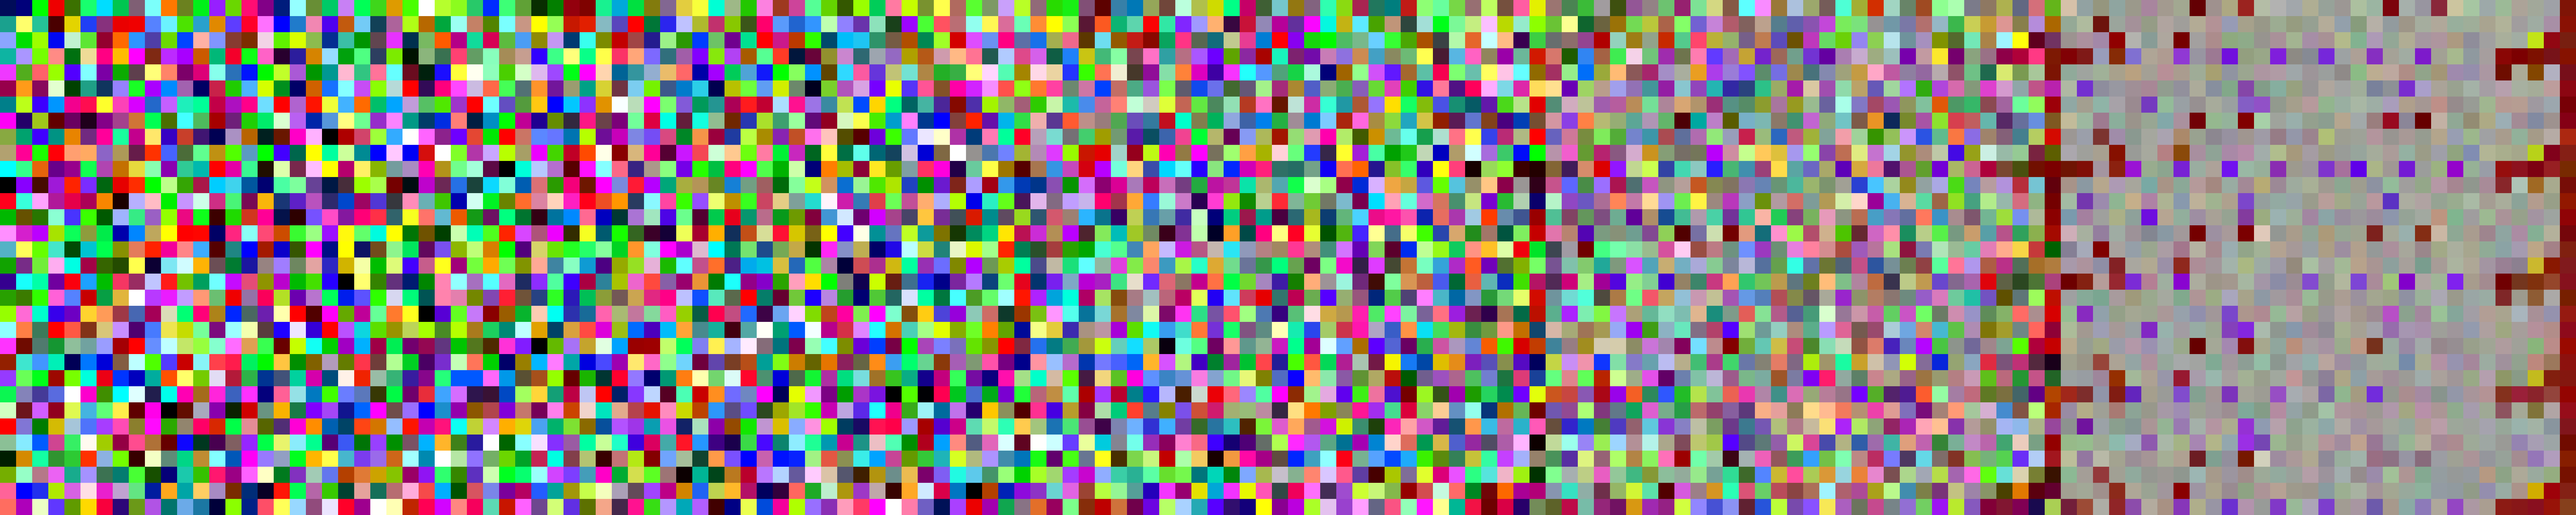

In [16]:
# from show_map import pixel_map_to_image_map

def p_xt(xt, noise, t):
    alpha_t = gather(alpha, t)
    alpha_bar_t = gather(alpha_bar, t)
    eps_coef = (1 - alpha_t) / (1 - alpha_bar_t) ** .5
    mean = 1 / (alpha_t ** 0.5) * (xt - eps_coef * noise) # Note minus sign
    var = gather(beta, t)
    eps = torch.randn(xt.shape, device=xt.device)
    return mean + (var ** 0.5) * eps 

x = torch.randn(1, 3, 32, 32) # Start with random noise
ims = []
for i in range(n_steps):
    t = torch.tensor(n_steps-i-1, dtype=torch.long)
    with torch.no_grad():
        pred_noise = unet_loaded(x.float(), t.unsqueeze(0))
        x = p_xt(x, pred_noise, t.unsqueeze(0))
        if i%24 == 0:
            ims.append(tensor_to_image(x.cpu()))

image_maps = []
image = Image.new('RGB', size=(32*5, 32))
for i, im in enumerate(ims[-5:]):
    image.paste(im, ((i%5)*32, 0))
    image_maps.append(pixel_map_to_image_map(im))
image.resize((32*UPSCALE_FACTOR*5, 32*UPSCALE_FACTOR), Image.NEAREST)

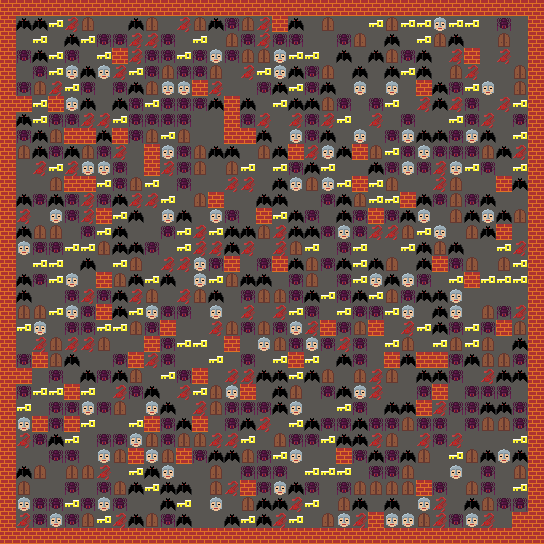

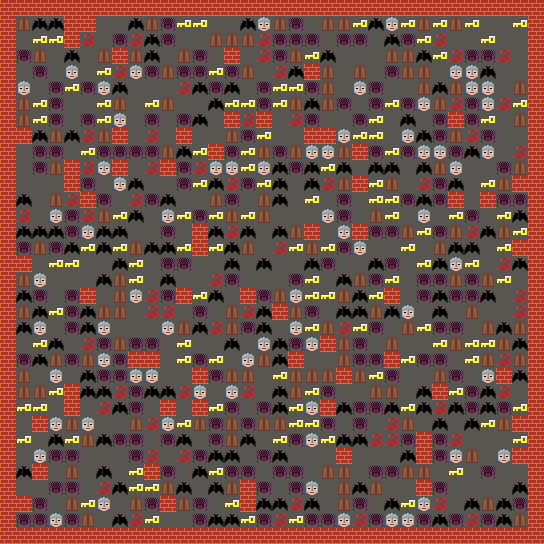

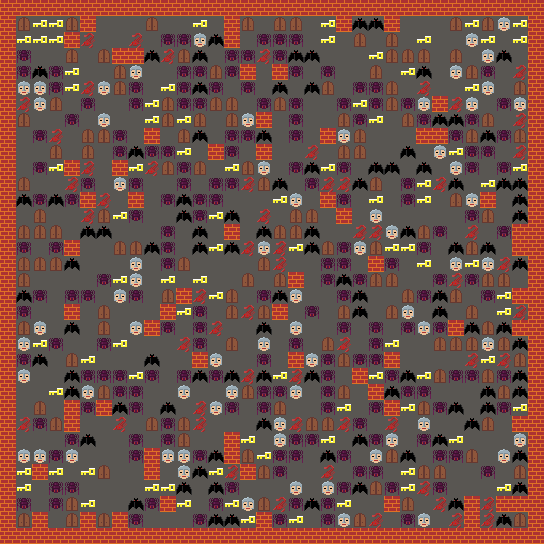

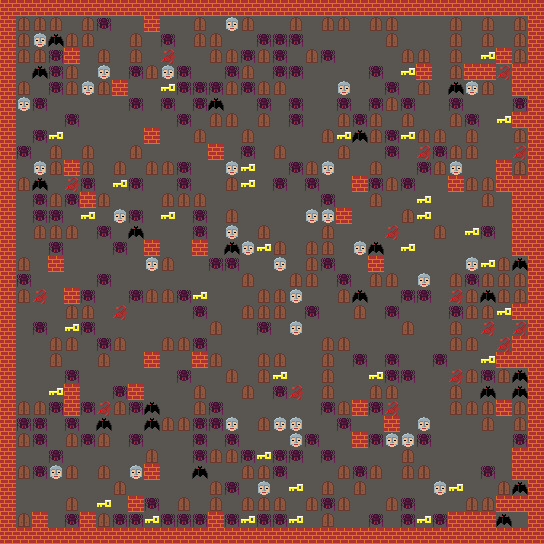

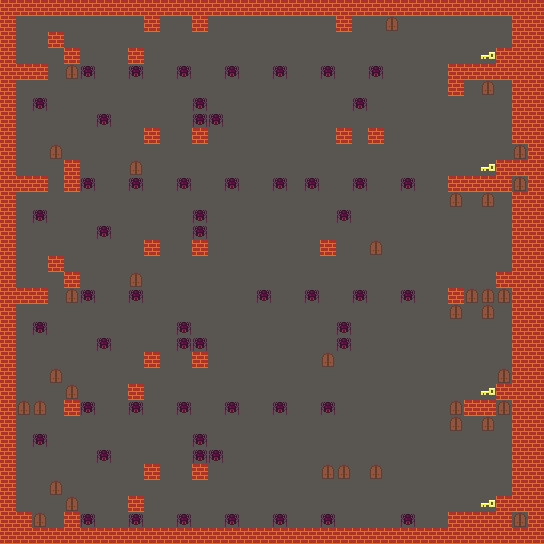

In [17]:
from IPython.display import Image, display

for im in image_maps[-5:]:
    display(im)

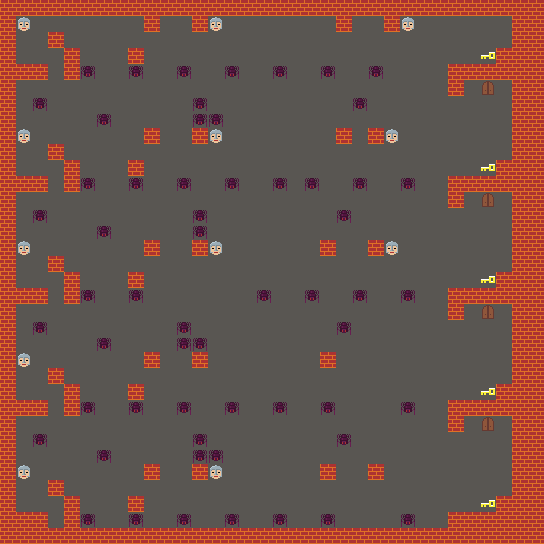

In [10]:
display(start_image_maps[0])

## Next Steps
1. Try all 50 levels, add padding and reflect each along x and y axis
2. function that maps from pixel map to image_map
4. Read function maps to colors (vs. gray scale)[DONE]
    
* Stable diffusion
* Understand diff between diffusion and PoD
* Talk to Debosmita about integrating PoD in 

* Talk to Debosmita about integrating PoD in 



### For next meeting
1. create inference script that can be called in PoD and Diffusion modes
   a. Convert to pixelated zelda map and run diffusion model on this map, then convert back to discrete space when passing to solver to determine if level is playable
2. create training script for diffusion model
4. create training script for PoD
5. train classifier on cifar dataset to be used 


- Discrete diffusion for functional objects
### Ongoing 
* Further my intuition for what is going on granularly in the noising and reversing steps on a given (understand the math behind it as well) - https://nn.labml.ai/diffusion/ddpm/index.html
* Dig into/understand the unet model architecture - https://arxiv.org/abs/1505.04597